In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../..")

In [12]:
import pandas as pd
from utils.intermediate_layer_extraction import return_layer_input
from utils.ri_calculator import computeRi,aggregateRi
import deepmatcher as dm
import torch

In [4]:
attributes =['Beer_Name','Brew_Factory_Name','Style','ABV']

In [5]:
model = dm.MatchingModel(attr_summarizer='hybrid')
model.load_state('../../models/beer_hybrid.pth')
model = model.cuda()

In [6]:
negatives = return_layer_input(model,model.classifier,'../../datasets/Structured/Beer/','negatives',0)

In [7]:
testneg = return_layer_input(model,model.classifier,'../../datasets/Structured/Beer/','test_negatives',0)

In [8]:
positives = return_layer_input(model,model.classifier,'../../datasets/Structured/Beer/','positives',1)

In [9]:
testpos = return_layer_input(model,model.classifier,'../../datasets/Structured/Beer/','test_positives',1)

In [10]:
classifier_len = len(list(positives.values())[0])
attribute_len = int(classifier_len/len(attributes))

## Negative analysis

In [11]:
testneg_ri,testneg_ri_norms = computeRi(model.classifier,attributes,negatives,0,aggregation_type='euclidean')
torch.save(testneg_ri,'experiment-results/neg_ri_hybrid.pt')

100%|██████████| 369/369 [01:04<00:00,  5.76it/s]


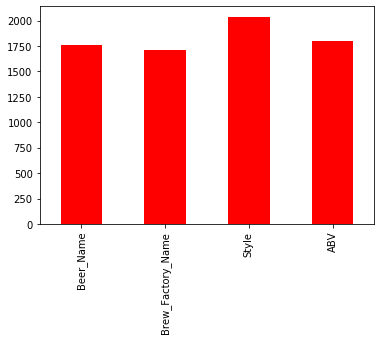

In [14]:
testneg_ri_norms.drop(['sample_id'],axis=1).sum().plot.bar(color='red')

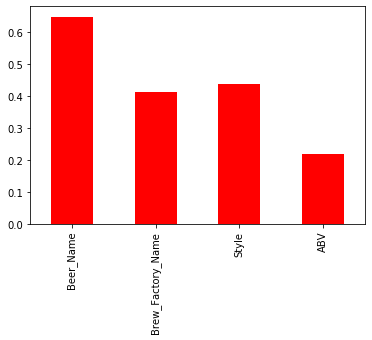

In [18]:
testneg_ri_cosine = aggregateRi(testneg_ri,negatives,attributes,attribute_len,'cosine')
testneg_ri_cosine.mean().plot.bar(color='red')

In [14]:
testneg_ri_norms.to_csv('experiment-results/neg_ri_norms_hybrid.csv',index=False)

## Positive analysis

In [19]:
testpos_ri,testpos_ri_norms = computeRi(model.classifier,attributes,positives,1,'euclidean')
torch.save(testpos_ri,'experiment-results/pos_ri.pt')

100%|██████████| 62/62 [00:12<00:00,  5.04it/s]


In [17]:
testpos_ri_norms.to_csv('experiment-results/pos_ri_norms.csv',index=False)

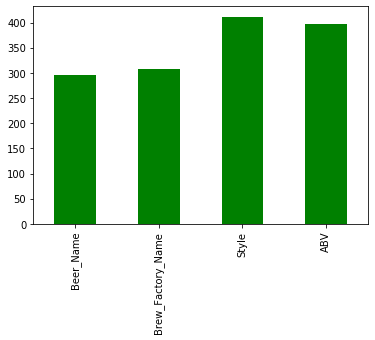

In [18]:
testpos_ri_norms.drop(['sample_id'],axis=1).sum().plot.bar(color='green')

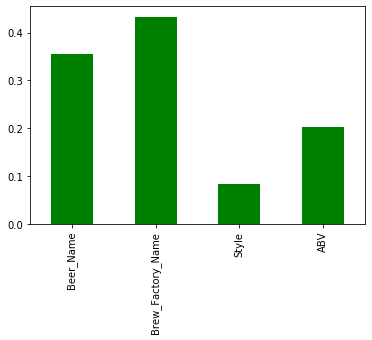

In [20]:
positives_ri_cosine = aggregateRi(testpos_ri,positives,attributes,attribute_len,'cosine')
positives_ri_cosine.mean().plot.bar(color='green')

## Compute closer vectors

### Considering all samples

In [20]:
from utils.distance_measures import nearestNeighborOnAttributes

In [26]:
##run this cell to load precomputed ri
positives_ri = torch.load('experiment-results/pos_ri.pt')
negatives_ri = torch.load('experiment-results/neg_ri.pt')

In [25]:
testpos_nn = nearestNeighborOnAttributes(testpos,testpos_ri,
                                                       negatives,attributes,attribute_len)

100%|██████████| 14/14 [00:00<00:00, 348.27it/s]


In [31]:
positives_nn = nearestNeighborOnAttributes(positives,pos_ri,
                                                       negatives,attributes,attribute_len)

100%|██████████| 68/68 [00:00<00:00, 459.86it/s]


In [28]:
testneg_nn = nearestNeighborOnAttributes(testneg,testneg_ri,
                                                        positives,attributes,attribute_len)

100%|██████████| 77/77 [00:00<00:00, 496.56it/s]


In [29]:
testpos_nn.to_csv('experiment-results/testpos_NNhybrid.csv',index=False)
testneg_nn.to_csv('experiment-results/testneg_NNhybrid.csv',index=False)

In [32]:
positives_nn.to_csv('experiment-results/positives_NN_hybrid.csv',index=False)

## Correct rankings

In [19]:
from utils.distance_measures import smallestDistanceOnAttributes,correctRankings

In [23]:
neg_ri = torch.load('experiment-results/neg_ri_hybrid.pt')
pos_ri = torch.load('experiment-results/pos_ri.pt')

In [24]:
testpos_nn_distances = smallestDistanceOnAttributes(positives,pos_ri,
                                                       negatives,attributes,attribute_len,distance_type='euclidean')
testneg_nn_distances = smallestDistanceOnAttributes(negatives,neg_ri,
                                                        positives,attributes,attribute_len,distance_type='euclidean')

100%|██████████| 369/369 [00:00<00:00, 1041.05it/s]


In [25]:
correct_rankings_testneg = correctRankings(testneg_ri_norms,testneg_nn_distances)
correct_rankings_testpos = correctRankings(testpos_ri_norms,testpos_nn_distances)

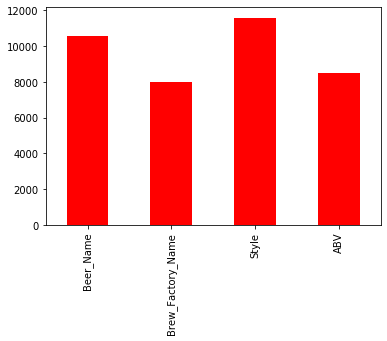

In [26]:
correct_rankings_testneg.drop(['sample_id'],axis=1).sum().plot.bar(color='red')

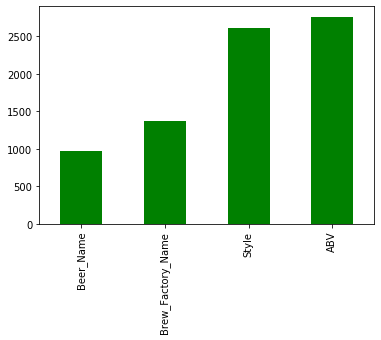

In [27]:
correct_rankings_testpos.drop(['sample_id'],axis=1).sum().plot.bar(color='green')

## Extract patterns

In [14]:
import collections
from collections import OrderedDict

In [15]:
def countTokens(attributes):
    allTokens = {}
    for attr in attributes:
        tokens = list(map(lambda s:s.lower(),attr.split()))
        for tok in tokens:
            if tok in allTokens:
                allTokens[tok] += 1
            else:
                allTokens[tok] = 1
    allOrderedTokens = OrderedDict(sorted(allTokens.items(), key=lambda t: t[1]))
    return allOrderedTokens

In [35]:
testpos_nn = pd.read_csv('experiment-results/testpos_NNhybrid.csv')
positives_nn = pd.read_csv('experiment-results/positives_NN_hybrid.csv')
negatives = pd.read_csv('../../datasets/Structured/Beer/negatives.csv')

In [36]:
testpos_nn_values = testpos_nn.merge(negatives,left_on='Beer_Name',right_on='id')
positives_nn_values = positives_nn.merge(negatives,left_on='Beer_Name',right_on='id')

In [38]:
collections.Counter(countTokens(testpos_nn_values.ltable_Beer_Name.values)).most_common(5)

[('ale', 9), ('red', 8), ('amber', 6), ('fire', 3), ('brew', 3)]

In [39]:
collections.Counter(countTokens(testpos_nn_values.rtable_Beer_Name.values)).most_common(5)

[('ale', 9), ('red', 8), ('amber', 6), ('conshohocken', 3), ('hale', 3)]

In [40]:
collections.Counter(countTokens(positives_nn_values.ltable_Beer_Name.values)).most_common(5)

[('ale', 41), ('red', 35), ('amber', 19), ('the', 14), ('legends', 12)]

In [41]:
collections.Counter(countTokens(positives_nn_values.rtable_Beer_Name.values)).most_common(5)

[('ale', 41), ('red', 34), ('of', 24), ('amber', 19), ('the', 13)]